## Application

### Environment Setup
- Defining the computational resource for implementing this project. (Not to Use GPU)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Library Imports

* Pandas and NumPy : for structured data manipulation and managing the dataset arrays
* Contractions and Strings : for implementing document nomalization such as removing special characters and noise
* Tensorflow and Scikit-learn : for design and training classification models like Multinomial Naive Bayes(MNB) and Bi-LSTM
* Scikit-learn : for implmenting MNB and calculating Accuracy, F1-Score, Classification Metrics and Confusion Matrix
* Matplotlib, WordCloud and Seaborn : for generating data exploration plots and model evaludation heatmaps

In [2]:
from datasets import load_dataset
import pandas as pd
import contractions
import string
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, RocCurveDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

2026-01-16 09:58:25.158195: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 09:58:25.196466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 09:58:26.032868: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/rooneyish/Applied_Machine_Learning/News_Article_Classification/.venv/lib/python3.11/s

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2026-01-16 09:58:26.270272: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-16 09:58:26.270292: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2026-01-16 09:58:26.270296: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2026-01-16 09:58:26.270299: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2026-01-16 09:58:26.270302: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: rooneyish
2026-01-16 09:58:26.270304: I external/local_xla/xla/stream_executor/cuda/cud

### Loading Dataset

In [4]:
ds = load_dataset("sh0416/ag_news")

In [5]:
# Concatinating into single DataFrame
df = pd.concat([ds['train'].to_pandas(), ds['test'].to_pandas()])

In [6]:
df.sample(5)

,label,title,description
41878,4,Intuit digs deeper into small businesses,A simplified version of the QuickBooks applica...
100378,3,Thoughts on Tysabri #39;s Approval,"For those that missed it last night, Biogen Id..."
82994,3,Verizon Wireless to Acquire NextWave Licenses ...,Verizon Wireless on Thursday announced an agre...
43883,4,INTERVIEW: HP Tries Built-To-Order PCs (Reuters),Reuters - U.S. computer company Hewlett-Packar...
31378,3,"Alitalia nears another critical labor accord, ...",MILAN Alitalia #39;s management and unions rep...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        127600 non-null  int64 
 1   title        127600 non-null  object
 2   description  127600 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [8]:
df.shape

(127600, 3)

In [9]:
df.isnull().sum()

label          0
title          0
description    0
dtype: int64

### Data Pre-Processing & Normalization

In [10]:
df.dropna(inplace = True)

In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df.drop_duplicates(inplace = True)

In [13]:
df = df.drop('title', axis = 1) # removing title of the article
df.sample(5)

,label,description
16348,4,Search Engine Keyword Trademark Infringements\...
99770,2,"During halftime Monday night, a man wearing a ..."
74316,4,USATODAY.com - Cingular said it closed its #3...
89924,2,Brown is a second year player from Memphis and...
97003,4,A massive eagle which became extinct five cent...


In [14]:
df = df.rename(columns={'label': 'y', 'description': 'X'})
df.head()

,y,X
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."


In [15]:
news_publishers = ['reuters', 'afp', 'ap', 'associated press', 'reuters news', 'bloomberg', 'cbc sports online']

def normalize_document(document):
    document = document.lower() # lowercase the texts
    document = contractions.fix(document) # converting don't --> do not 
    document = document.translate(str.maketrans('','',string.punctuation)) # removing special characters
    for publisher in news_publishers: # removing names of the news article publishers from the document
        document = document.replace(publisher, '')
    document = " ".join(document.split()) # removing whitespaces from the documents
    return document

In [16]:
df['X'] = df['X'].apply(normalize_document)

In [17]:
df.sample(5)

,y,X
49003,4,former con artist frank abagnale whose life wa...
107305,1,vice president dick cheney will lead the us de...
19892,2,former lightweight champion paul spadafora was...
6032,1,the israeli prime minister ariel sharon ologiz...
73972,1,an amnesty international report criticises the...


The document is now cleaned and normalized.

## Exploratory Data Analysis

### Class Imbalance Check

Checking if the dataset contains imbalanced classes. 

Text(0.5, 1.0, 'News Categories by No. of samples')

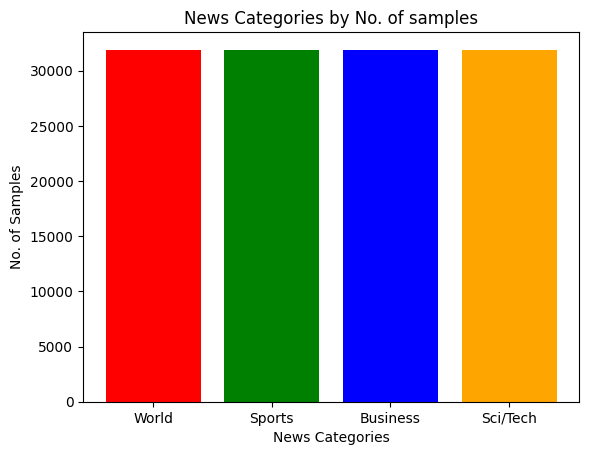

In [18]:
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

plt.bar(class_names, df['y'].value_counts().sort_index(), color = ['red', 'green', 'blue', 'orange'])
plt.ylabel('No. of Samples')
plt.xlabel('News Categories')
plt.title('News Categories by No. of samples')

### Word Cloud Analysis by Categories

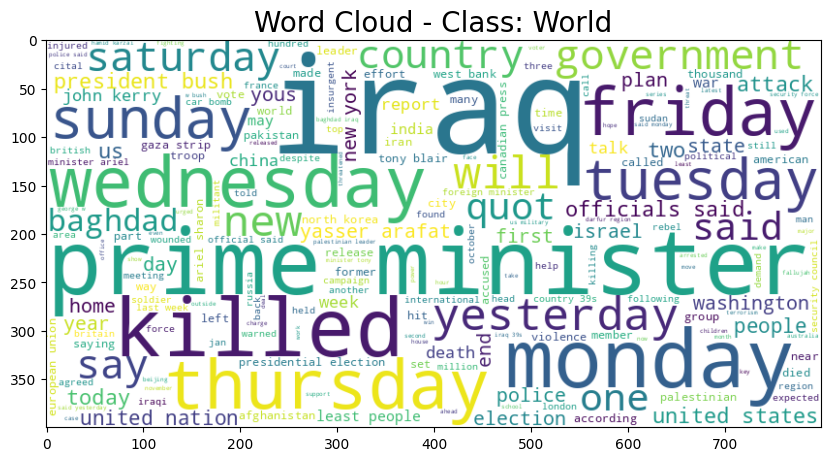

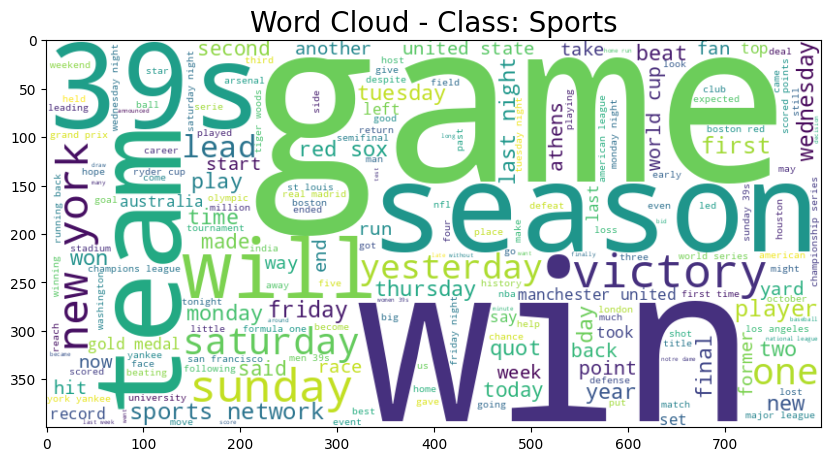

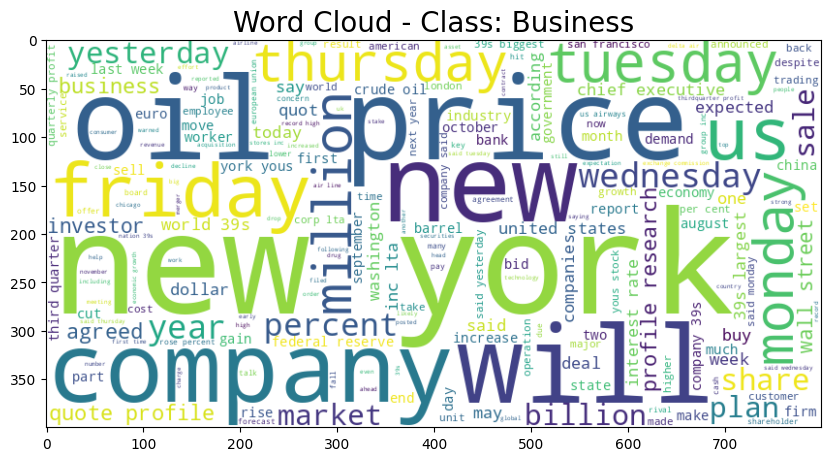

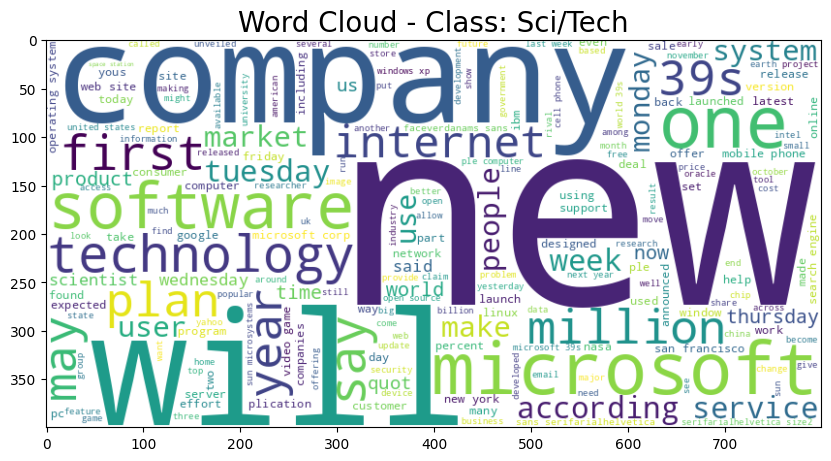

In [19]:
classes = sorted(df['y'].unique())

for category in classes:
    text_data = " ".join(df[df['y'] == category]['X'].astype(str))
        
    wc = WordCloud(
        width=800,
        height= 400,
        background_color='white',
        stopwords=set(STOPWORDS)
    ).generate(text_data)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    label_idx = int(category)-1
    plt.title(f'Word Cloud - Class: {class_names[label_idx]}', fontsize=20)

#### Business
The Business Category in this News Article Dataset is heavily centered around corporate entities.
The most dominant terms in this categories are:
* oil
* price
* new york
* company

#### Sci/Tech
Science and Technology category highlights the major factors and platfroms in the digital landscape.
The dominant keywords in this class are:
* software
* microsoft
* technology
* company
* internet

#### World
This class in the dataset is dominated mostly by geopolitical conflicts and international leadership.
Most Dominant Terms presented are:
* Iraq
* prime minster
* killed
* governmnet

#### Sports
The Sports category reflects a focus on copetition resuls and major leagues.
Dominant Keywords are:
* win
* game
* team
* season
* victory

## Train, Validation & Test Split

Splitting the DataFrame into 3 three parts for Training, Cross Validation and Testing. \
Train: 60% \
Validation: 20% \
Test: 30% 

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(df['X'], df['y'], test_size=0.4, random_state=42, stratify=df['y'])
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [21]:
X_train.shape, X_val.shape, X_test.shape

((76560,), (25520,), (25520,))

## Feature Extraction

### Multinomial Naive Bayes - Feature Extraction

#### Implementing TF-IDF Vectorization for Multinomial Naive Bayes

In [22]:
tfidf = TfidfVectorizer()

In [23]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [24]:
tfidf.get_feature_names_out()[:20]

array(['00', '000', '000660se', '000th', '0013', '0013hk', '002', '004',
       '005', '005930ks', '007', '008', '009', '01', '010', '0100', '011',
       '01102004', '011104', '012'], dtype=object)

In [25]:
tfidf.vocabulary_

{'well': 72054,
 'we': 71802,
 'finally': 26186,
 'have': 30981,
 'an': 8056,
 'official': 46566,
 'introduction': 35234,
 'of': 46452,
 'both': 12803,
 'the': 66076,
 'giants': 28916,
 '39': 3249,
 'dualcore': 22472,
 'cpu': 18661,
 'power': 50890,
 'quotintel': 53382,
 'and': 8149,
 'amd': 7869,
 'must': 44186,
 'come': 17000,
 'to': 67204,
 'same': 57919,
 'conclusions': 17475,
 'earlier': 22770,
 'this': 66621,
 'decade': 19994,
 'since': 60503,
 'today': 67265,
 'seen': 59034,
 'server': 59388,
 'demonstrations': 20485,
 'with': 72862,
 '90nm': 5529,
 'chips': 15847,
 'from': 27838,
 'companies': 17178,
 'ketchup': 37249,
 'maker': 40668,
 'saw': 58223,
 'its': 35784,
 'profit': 51689,
 'fall': 25414,
 'as': 9264,
 'it': 35717,
 'spun': 62340,
 'off': 46504,
 'units': 69571,
 'del': 20318,
 'monte': 43367,
 'but': 13974,
 'new': 45055,
 'items': 35752,
 'boosted': 12696,
 'sales': 57827,
 'chicago': 15717,
 'manufacturer': 40954,
 'hj': 31972,
 'heinz': 31306,
 'co': 16595,
 'ple'

### Bi-LSTM - Feature Extraction

#### Implementing Keras Tokenizer for Tokenization & GloVe Embedding for Vectorization

In [26]:
y_train_dl = y_train- 1
y_val_dl = y_val - 1
y_test_dl = y_test - 1

In [27]:
# Loading GloVe 
glove_path = 'glove.6B.100d.txt'

def load_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_embeddings(glove_path)

In [28]:
max_words = 20000
max_len = 100

In [29]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [30]:
embedding_dim = 100
word_index = tokenizer.word_index
word_index

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 'that': 9,
 '39s': 10,
 'with': 11,
 'as': 12,
 'is': 13,
 'its': 14,
 'at': 15,
 'said': 16,
 'it': 17,
 'by': 18,
 'has': 19,
 'new': 20,
 'an': 21,
 'from': 22,
 'his': 23,
 'will': 24,
 'was': 25,
 'after': 26,
 'have': 27,
 'be': 28,
 'their': 29,
 'are': 30,
 'over': 31,
 'he': 32,
 'us': 33,
 'two': 34,
 'but': 35,
 'first': 36,
 'this': 37,
 'more': 38,
 'monday': 39,
 'not': 40,
 'tuesday': 41,
 'wednesday': 42,
 'thursday': 43,
 'up': 44,
 'company': 45,
 'inc': 46,
 'friday': 47,
 'one': 48,
 'world': 49,
 'they': 50,
 'york': 51,
 'last': 52,
 'yesterday': 53,
 'against': 54,
 'than': 55,
 'were': 56,
 'who': 57,
 'about': 58,
 'into': 59,
 'year': 60,
 'been': 61,
 'president': 62,
 'out': 63,
 'yous': 64,
 'had': 65,
 'when': 66,
 'would': 67,
 'oil': 68,
 'corp': 69,
 'million': 70,
 'united': 71,
 'sunday': 72,
 'week': 73,
 'years': 74,
 'which': 75,
 'people': 76,
 'could': 77,
 'three'

In [31]:
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model Training

### Multinomial Naive Bayes

In [32]:
# Attempt 1
MNB_model = MultinomialNB(alpha=1.0) # Intializing Model
MNB_model.fit(X_train_tfidf,y_train) # Training Model
#-----------------------------------------------------------#
# Attempt 2
# MNB_model = MultinomialNB(alpha=2.0) # Intializing Model
# MNB_model.fit(X_train_tfidf,y_train) # Training Model
#-----------------------------------------------------------#
# Attempt 3
# MNB_model = MultinomialNB(alpha=3.0) # Intializing Model
# MNB_model.fit(X_train_tfidf,y_train) # Training Model

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


### Bi-LSTM 

In [33]:
# Defining Bi-LSTM Model
LSTM_model = Sequential([       
    Input(shape=(num_words,)),
    Embedding(num_words, 
              embedding_dim, 
              weights=[embedding_matrix], 
              trainable=False), 
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax') 
])

In [34]:
#Attempt 3 
# optimizer = Adam(learning_rate = 0.01)
# LSTM_model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#--------------------------------------------------------------------------------------------------------------------#

# #Attempt 2 
# optimizer = Adam(learning_rate = 0.0001)
# LSTM_model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# #--------------------------------------------------------------------------------------------------------------------#

# Attempt 1 - with Learning Rate = 0.001
LSTM_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20000, 100)     │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,088,740 (7.97 MB)

 Trainable params: 88,740 (346.64 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [35]:
history = LSTM_model.fit(X_train_pad, y_train_dl, epochs=10, batch_size=64, 
                    validation_data=(X_val_pad, y_val_dl))

Epoch 1/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.8580 - loss: 0.4046 - val_accuracy: 0.8872 - val_loss: 0.3228
Epoch 2/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8885 - loss: 0.3207 - val_accuracy: 0.8950 - val_loss: 0.3089
Epoch 3/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8963 - loss: 0.2997 - val_accuracy: 0.8951 - val_loss: 0.3007
Epoch 4/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9009 - loss: 0.2824 - val_accuracy: 0.9016 - val_loss: 0.2877
Epoch 5/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9056 - loss: 0.2688 - val_accuracy: 0.8966 - val_loss: 0.2935
Epoch 6/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.9105 - loss: 0.2561 - val_accuracy: 0.9046 - val_loss: 0.2767
Epoch 7/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9147 - loss: 0.2433 - val_accuracy: 0.9069 - val_loss: 0.2763
Epoch 8/10
1197/1197 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9184 -

## Model Evaluation

### Multinomial Naive Bayes

In [36]:
y_test_binarized = label_binarize(y_test_dl, classes=[0,1,2,3])

y_train_pred_MNB = MNB_model.predict(X_train_tfidf)
y_val_pred_MNB = MNB_model.predict(X_val_tfidf)
y_test_pred_MNB = MNB_model.predict(X_test_tfidf)
y_test_score_MNB = MNB_model.predict_proba(X_test_tfidf)

In [37]:
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

Evaluation - Multinomial Naive Bayes
Train Accuracy: 91.36%
Validation Accuracy: 89.44%
Test Accuracy: 89.59% 

Train F1 Score: 0.91
Validation F1 Score: 0.89
Test F1 Score: 0.90 

              precision    recall  f1-score   support

       World     0.9013    0.8912    0.8962      6380
      Sports     0.9447    0.9755    0.9599      6380
    Business     0.8644    0.8589    0.8616      6380
    Sci/Tech     0.8711    0.8578    0.8644      6380

    accuracy                         0.8959     25520
   macro avg     0.8954    0.8959    0.8955     25520
weighted avg     0.8954    0.8959    0.8955     25520



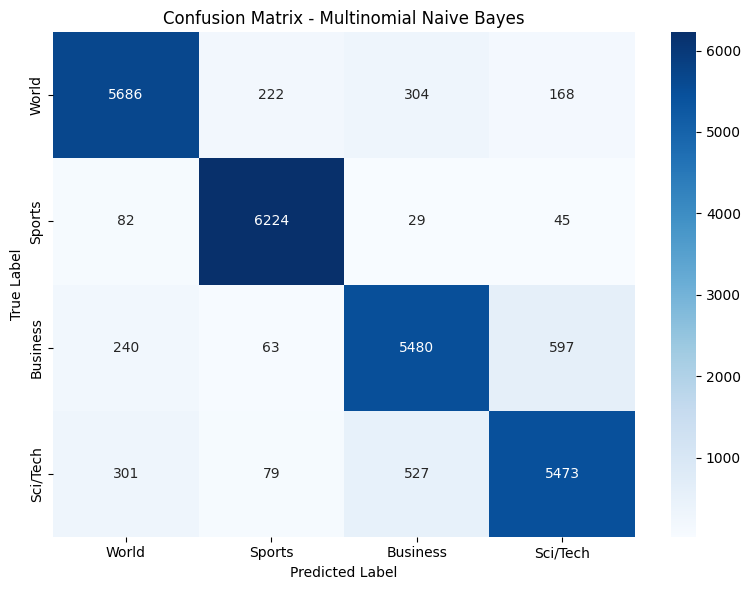

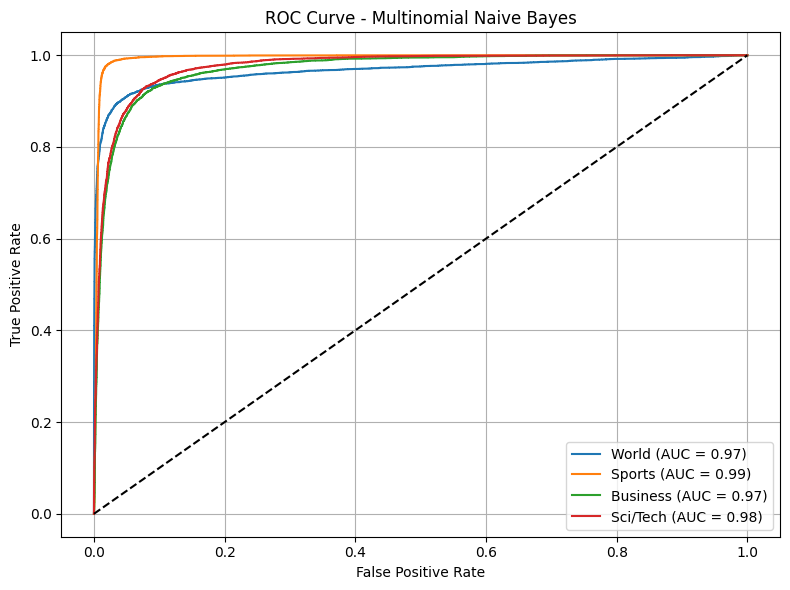

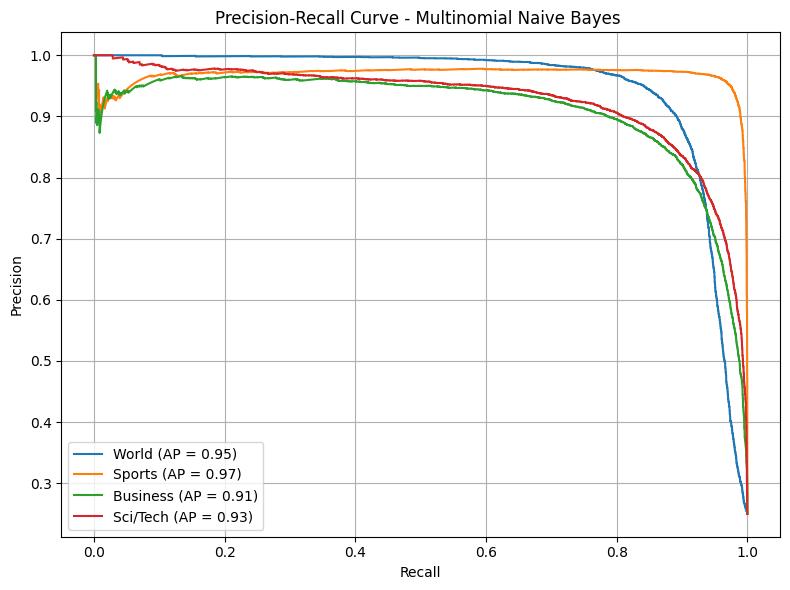

In [42]:
train_accuracy_MNB = accuracy_score(y_train, y_train_pred_MNB)
train_f1_score_MNB = f1_score(y_train, y_train_pred_MNB, average='weighted')

val_accuracy_MNB = accuracy_score(y_val, y_val_pred_MNB)
val_f1_score_MNB = f1_score(y_val, y_val_pred_MNB, average='weighted')

test_accuracy_MNB = accuracy_score(y_test, y_test_pred_MNB)
test_f1_score_MNB = f1_score(y_test, y_test_pred_MNB, average='weighted')

print(f"Evaluation - Multinomial Naive Bayes")
print(f"Train Accuracy: {train_accuracy_MNB*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy_MNB*100:.2f}%")
print(f"Test Accuracy: {test_accuracy_MNB*100:.2f}% \n")
print(f"Train F1 Score: {train_f1_score_MNB:.2f}")
print(f"Validation F1 Score: {val_f1_score_MNB:.2f}")
print(f"Test F1 Score: {test_f1_score_MNB:.2f} \n")


print(classification_report(y_test,y_test_pred_MNB, target_names=class_names, digits=4))

cm_MNB = confusion_matrix(y_test, y_test_pred_MNB)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_MNB,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(
        y_test_binarized[:, i],
        y_test_score_MNB[:, i]
    )
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f"{class_names[i]} (AUC = {roc_auc:.2f})"
    )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multinomial Naive Bayes")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))

for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(
        y_test_binarized[:, i],
        y_test_score_MNB[:, i]
    )
    
    avg_precision = average_precision_score(
        y_test_binarized[:, i],
        y_test_score_MNB[:, i]
    )
    
    plt.plot(
        recall,
        precision,
        label=f"{class_names[i]} (AP = {avg_precision:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Multinomial Naive Bayes ")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

### Bi-LSTM

In [39]:
y_train_pred_LSTM = LSTM_model.predict(X_train_pad)
y_val_pred_LSTM = LSTM_model.predict(X_val_pad)
y_test_pred_LSTM = LSTM_model.predict(X_test_pad)

2393/2393 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step
798/798 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
798/798 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


Evaluation - Bi-LSTM
Train Accuracy: 93.66%
Validation Accuracy: 90.65%
Test Accuracy: 90.79% 

Train F1 Score: 0.94
Validation F1 Score: 0.91
Test F1 Score: 0.91 

              precision    recall  f1-score   support

       World     0.9345    0.8923    0.9129      6380
      Sports     0.9556    0.9820    0.9686      6380
    Business     0.8679    0.8777    0.8728      6380
    Sci/Tech     0.8740    0.8795    0.8767      6380

    accuracy                         0.9079     25520
   macro avg     0.9080    0.9079    0.9078     25520
weighted avg     0.9080    0.9079    0.9078     25520



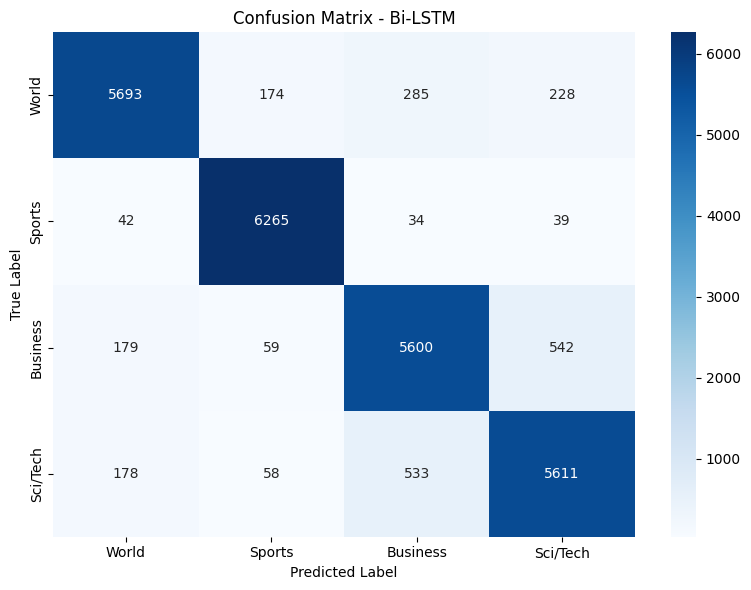

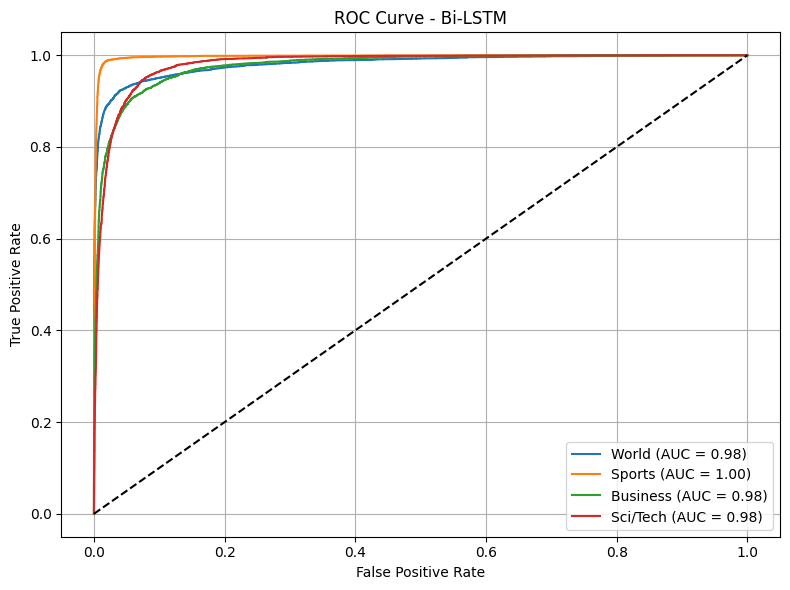

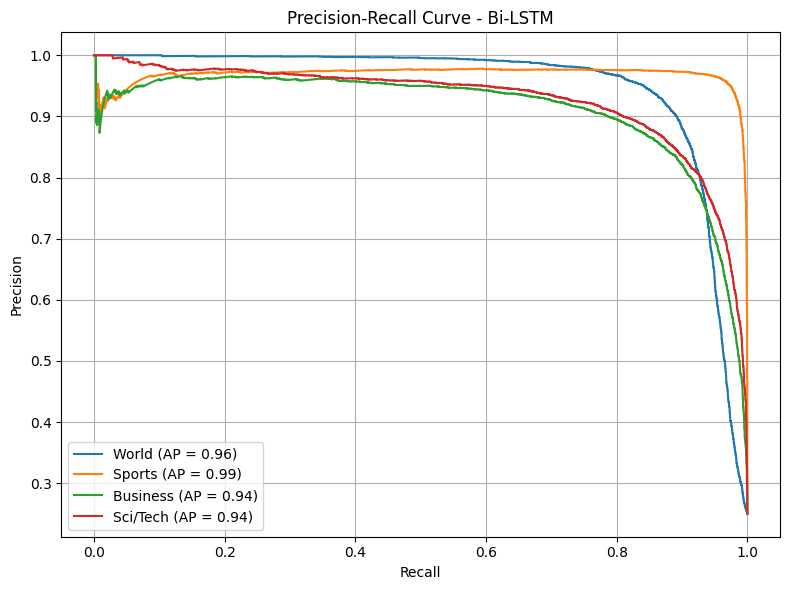

In [41]:
train_accuracy_LSTM = accuracy_score(y_train_dl, np.argmax(y_train_pred_LSTM, axis = 1))
train_f1_score_LSTM = f1_score(y_train_dl, np.argmax(y_train_pred_LSTM, axis = 1), average='weighted')
val_accuracy_LSTM = accuracy_score(y_val_dl, np.argmax(y_val_pred_LSTM, axis = 1))
val_f1_score_LSTM = f1_score(y_val_dl, np.argmax(y_val_pred_LSTM, axis = 1), average='weighted')
test_accuracy_LSTM = accuracy_score(y_test_dl, np.argmax(y_test_pred_LSTM, axis = 1))
test_f1_score_LSTM = f1_score(y_test_dl, np.argmax(y_test_pred_LSTM, axis = 1), average='weighted')


print(f"Evaluation - Bi-LSTM")
print(f"Train Accuracy: {train_accuracy_LSTM*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy_LSTM*100:.2f}%")
print(f"Test Accuracy: {test_accuracy_LSTM*100:.2f}% \n")
print(f"Train F1 Score: {train_f1_score_LSTM:.2f}")
print(f"Validation F1 Score: {val_f1_score_LSTM:.2f}")
print(f"Test F1 Score: {test_f1_score_LSTM:.2f} \n")

print(classification_report(y_test_dl,np.argmax(y_test_pred_LSTM, axis = 1), target_names=class_names, digits=4))

cm_LSTM = confusion_matrix(y_test_dl, np.argmax(y_test_pred_LSTM, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_LSTM,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Bi-LSTM")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(
        y_test_binarized[:, i],
        y_test_pred_LSTM[:, i]
    )
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        label=f"{class_names[i]} (AUC = {roc_auc:.2f})"
    )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Bi-LSTM")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))

for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(
        y_test_binarized[:, i],
        y_test_score_MNB[:, i]
    )
    
    avg_precision = average_precision_score(
        y_test_binarized[:, i],
        y_test_pred_LSTM[:, i]
    )
    
    plt.plot(
        recall,
        precision,
        label=f"{class_names[i]} (AP = {avg_precision:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Bi-LSTM")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()